In [5]:
library(dplyr)
library(coda)
library(rjags)

## Markov chain Monte Carlo 

#### Markov chain example 

Sia un punto in uno dei nodi della Markov chain; attraverso la matrice densità di probabilità di transizione è possibile osservare l'evoluzione temporale della probabilità che quel punto si trovi nel primo, nel secondo o nel terzo nodo. Infatti:
$$ Y' = YP $$
* $P$ è la matrice che stabilisce la probabilità di transizione dallo stato $i$ allo stato $j$, cioè $P(i\rightarrow j)$; 
* $Y$ invece è un vettore riga le cui componenti corrispondono alla probabilità che un punto si trovi all'istante dell'iterazione $t$ nello stato 1,2,3.

Le tre matrici che abbiamo ottenuto dalla funzione `iterate.P` sono array di dimensione n+1 x length(x) ovvero hanno tante righe quante sono il numero di iterazioni più uno, che è lo stato iniziale, e tante colonne invece quante sono le componenti del vettore x cioè quanti stati può visitare un punto per ogni iterazione. In questo caso la catena è la più semplice possibile in quanto ogni punto può spostarsi, in una dimensione, verso lo stato in cui già si trova oppure nei due accanto; pertanto il vettore x è tridimensionale.

Cosa rappresentano dunque le nove traiettorie che osserviamo nel plot?
<br> Se ogni riga delle matrici che stiamo rappresentando sono le probabilità di trovarsi, all'istante $t$, nei tre stati allora una traiettoria corrisponde ad una colonna. Per ciascun vettore rappresentiamo l'evoluzione temporale della probabilità di trovarsi in un determinato nodo (i colori diversi sono per l'appunto i tre stati della catena). Ogni vettore produce tre "traiettorie" ciascuna di un colore diverso ovvero collegata ad un nodo differente. Ciò che osserviamo è che dopo un esiguo numero di iterazioni tali traiettorie convergono negli stessi punti, tre punti per tre nodi diversi con tre colori.

I tre stati iniziali inoltre rappresentano: 
- un punto che parte dal nodo centrale $(0,1,0)$
- un punto che parte dal nodo a destra $(0,0,1)$
- un punto che parte dal nodo a sinistra $(1,0,0)$

La catena è quindi lunga soltanto tre nodi come già avevamo pensato analizzando l'evoluzione di un generico vettore y.

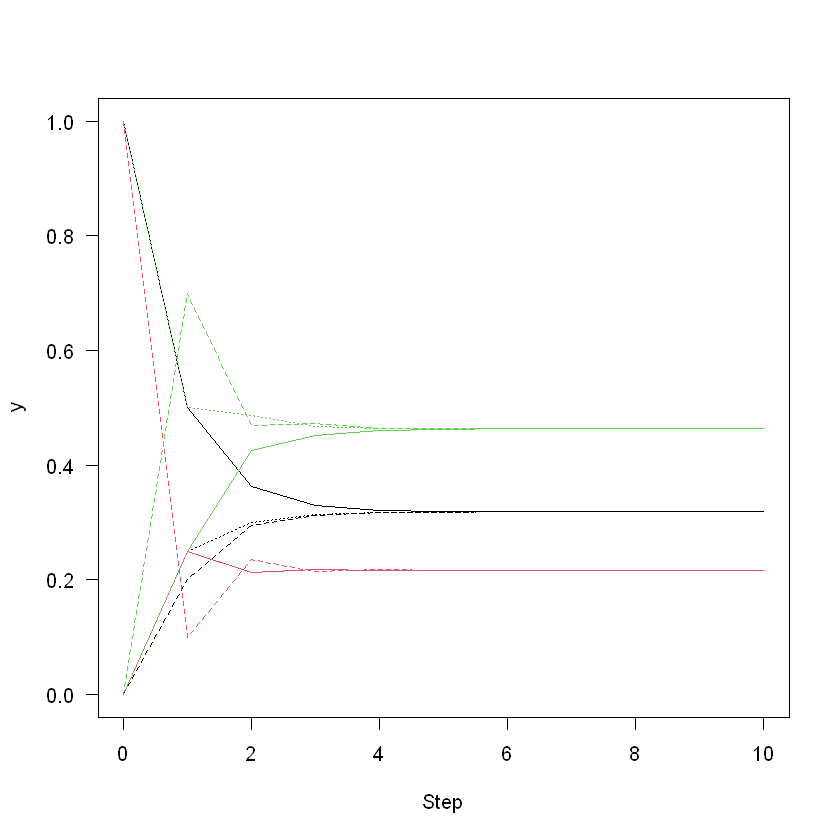

In [2]:
P <- rbind(c(.5,  .25, .25),
           c(.2,  .1,  .7),
           c(.25, .25, .5))

iterate.P <- function(x, P, n) {
    res <- matrix(NA, n+1, length(x))
    res[1,] <- x
    for (i in seq(n))
        res[i+1,] <- x <- x %*% P
        # oppure anche res[i+1,] <- res[i,] %*% P
    res
}

n <- 10
y1 <- iterate.P(c(1, 0, 0), P, n)
y2 <- iterate.P(c(0, 1, 0), P, n)
y3 <- iterate.P(c(0, 0, 1), P, n)

matplot(0:n, y1, type="l", lty=1, xlab="Step", ylab="y", las=1)
matlines(0:n, y2, lty=2)
matlines(0:n, y3, lty=3)

#### Decomposizione spettrale della matrice di transizione $P(i\rightarrow j)$
In che modo possiamo verificare che le traiettorie convergano verso i "punti fissi" determinati dalla matrice di transizione di probabilità?
<br> Innanzitutto bisogna capire cosa siano e da cosa vengano rappresentati gli attrattori di questa Markov chain. I punti fissi sono le tre componenti dell'autovettore di autovalore $\lambda=1$ della matrice di transizione di probabilità. Pertanto quando un vettore assume i valori di $v_{1}$ esso rimane invariato anche dopo una successiva iterazione, ovvero moltiplicandolo per $P$. 

$$ {v_1}^T P = {v_1}^T \ \ \ \text{dove}\ v_1^T \ \text{e' un vettore riga}$$

Cerchiamo di conseguenza tre punti che sono anche le tre probabilità finali di trovarsi nei tre differenti nodi della catena.
Ricordiamoci che per come è stata scritta l'evoluzione temporale dei vari stati stiamo considerando l'autovettore sinistro di autovalore $\lambda=1$ ottenuto risolvendo l'equazione agli autovalori con la trasposta della matrice di transizione: 
$$ P^T v_1 = v_1$$

In [3]:
v <- eigen(t(P))$vectors[,1]
v <- v/sum(v)

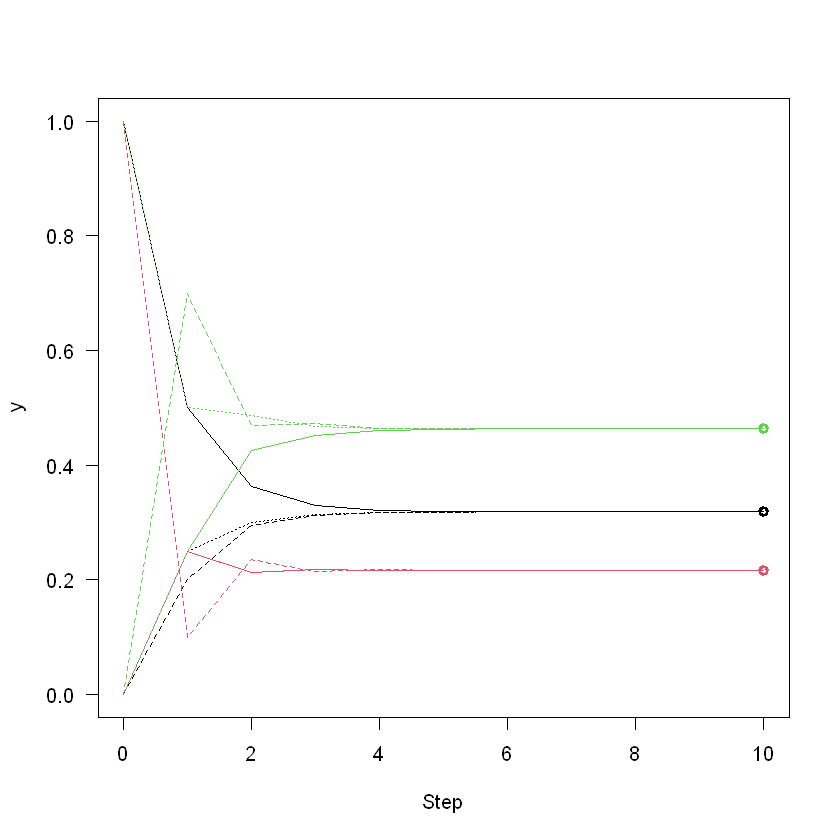

In [4]:
matplot(0:n, y1, type="l", lty=1, xlab="Step", ylab="y", las=1)
matlines(0:n, y2, lty=2)
matlines(0:n, y3, lty=3)
points(rep(10, 3), v, col=1:3, lwd=3)
# in questa maniera vediamo quanto dopo soltanto dieci iterazioni ci avviciniamo alla convergenza per i tre stati y1, y2, y3

Anzichè analizzare i vettori delle probabilità di trovarsi in uno stato studiamo l'evoluzione temporale di un punto che si muove seguendo le transizioni di probabilità da un nodo all'altro. Per capire come si muoverà il punto possiamo utilizzare la funzione `sample` che sceglie un punto tra 1,2,3 (ovvero da uno al numero di colonne della matrice P), pesato attraverso le tre probabilità $P[i,]$, dove $i$ è la riga corrispondente al punto in cui ci troviamo nell'istante dell'iterazione precedente. 

In [5]:
P[1,]
# sono ad esempio le probabilità di transizione dal primo nodo al primo, secondo, terzo

[1] 0.50 0.25 0.25

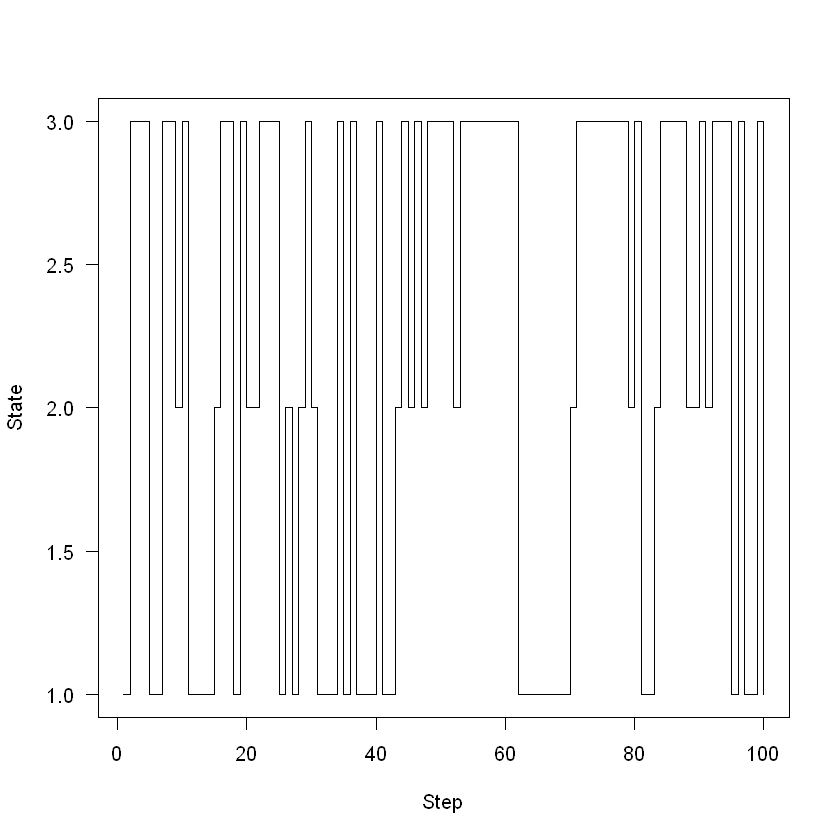

In [6]:
run <- function(i, P, n) {
    res <- rep(0,n)
    # creo un array di n zeri quanti il numero di iterazioni della markov chain
    for (t in seq(n))
        res[t] <- i <- sample(nrow(P), 1, pr=P[i,])
    # ad ogni istante cambia sia i che sarà il nuovo punto di partenza per la successiva iterazione che di conseguenza il punto ottenuto 
    # come risultato dall'iterazione stessa cioè res[t], i due valori sono naturalmente uguali ma servono a scopi differenti.
    res
}

samples <- run(1, P, 100)
plot(samples, type="s", xlab="Step", ylab="State", las=1)

Rappresentiamo, anzichè lo stato in cui ci troviamo, la frazione di tempo che il punto ha passato in ciascun nodo al variare del tempo stesso

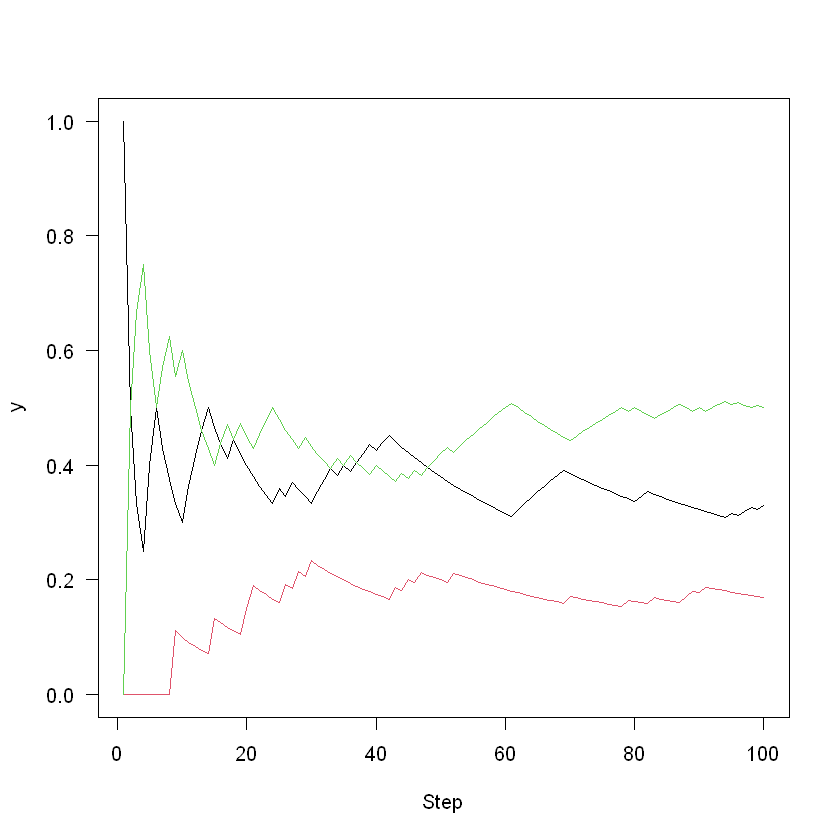

In [7]:
plot(cummean(samples == 1), type="l", ylim=c(0, 1),
     xlab="Step", ylab="y", las=1)
lines(cummean(samples == 2), col=2)
lines(cummean(samples == 3), col=3)

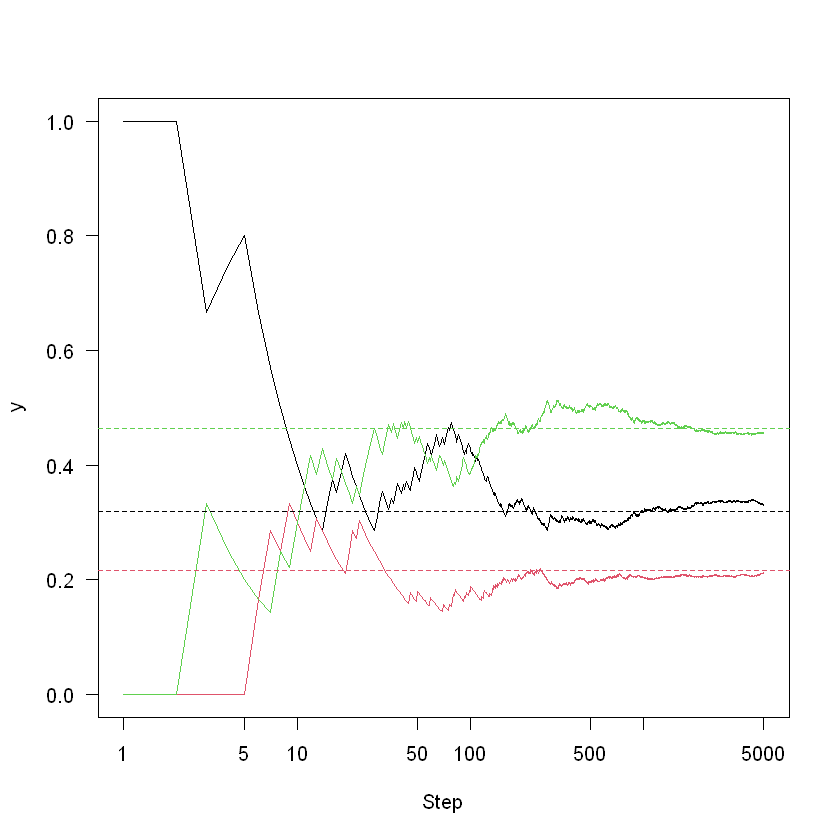

In [8]:
n <- 5000
set.seed(1)
samples <- run(1, P, n)
plot(cummean(samples == 1), type="l", ylim=c(0, 1), log="x",
     xlab="Step", ylab="y", las=1)
lines(cummean(samples == 2), col=2)
lines(cummean(samples == 3), col=3)
abline(h=v, lty=2, col=1:3)

#### Metropolis algorithm
A partire da quanto abbiamo visto precedentemente a proposito delle Markov chain sfruttiamo la proprietà per cui un punto sia in grado di esplorare tutti i nodi che le costituiscono. Lo scopo dell'algoritmo di Metropolis è estrarre dei samples indirettamente da una distribuzione di probabilità nota $p(x)$; esplorando interamente le regioni dove la distribuzione di probabilità è più piccata MCMC è in grado di recuperarvi punti quando metodi globali come **accept-reject** non riescono.

Per costruire una MCMC è necessario avere a disposizione una distribuzione $p(x)$ che possa essere valutata facilmente nei punti di interesse; inoltre per saltare da un punto all'altro bisogna considerare una soglia di accettabilità la quale viene determinata da una $\textit{proposal distribution}$. Quest ultima in questo caso è presa simmetrica ovvero 
$$P(x \rightarrow  x') = P(x' \rightarrow  x)$$

L'algoritmo procede in questo modo:
* Si inizia in uno stato $x_t$
* si propone uno stato successivo $x'$
* si calcola la acceptance probability $$\alpha = min\left[1,\frac{p(x')}{p(x)}\right]$$

successivamente per capire se effettivamente passare da un punto a quello proposto si estrae un numero, $u$, uniformemente dall'intervallo $[0,1]$ e si confronta con $\alpha$.
* se  $u<\alpha$ si accetta il punto, ponendo $x_{t+1}=x'$. Altrimenti si rifiuta e si pone $x_{t+1}=x_t$.

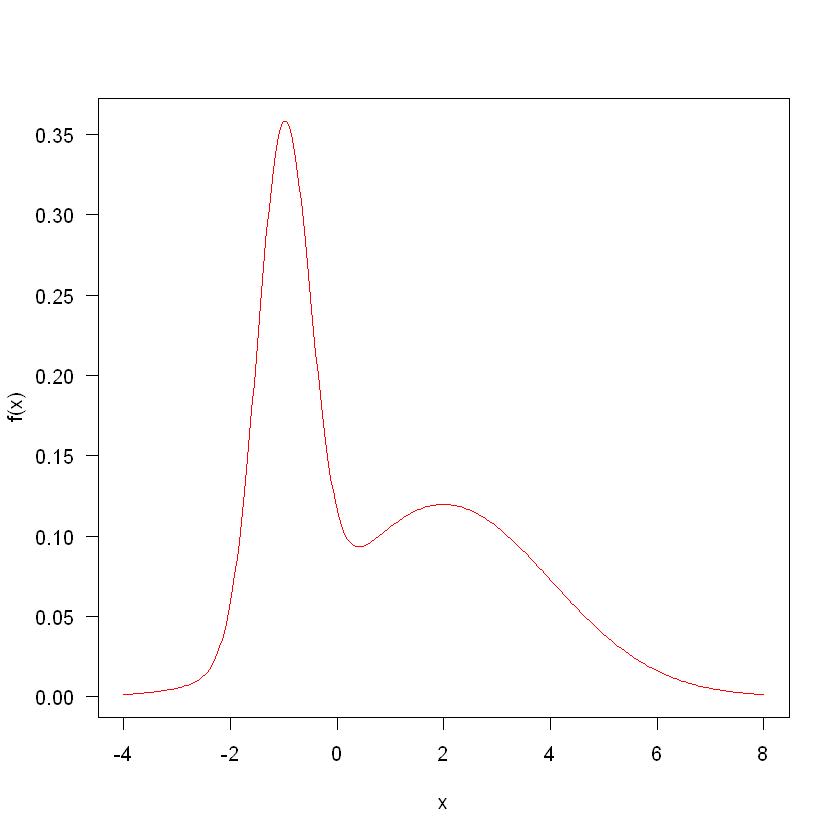

In [9]:
# costruisco la funzione da cui voglio estrarre i sample 
p <- 0.4
mu <- c(-1, 2)
sd <- c(.5, 2)
f <- function(x)
    p     * dnorm(x, mu[1], sd[1]) +
    (1-p) * dnorm(x, mu[2], sd[2])

curve(f(x), col="red", -4, 8, n=301, las=1)

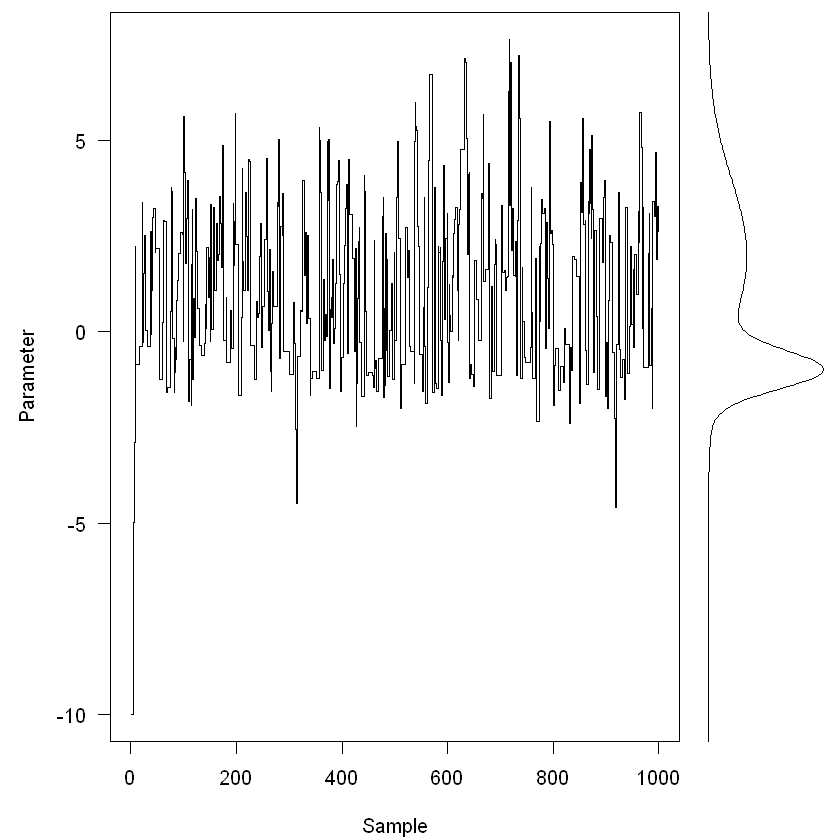

In [46]:
q <- function(x) rnorm(1, x, 4)


step <- function(x, f, q) {
    ## Pick new point
    xp <- q(x)
    ## Acceptance probability:
    alpha <- min(1, f(xp) / f(x))
    ## Accept new point with probability alpha:
    # sia che nel nuovo punto la probabilità fosse maggiore rispetto al punto precedente sia il contrario bisogna comunque passare per il 
    # processo di acceptance estraendo un valore uniformemente in [0,1]
    if (runif(1) < alpha)
        x <- xp
    ## Returning the point:
    x
}

run <- function(x, f, q, nsteps) {
    res <- matrix(NA, nsteps, length(x))
    for (i in seq(nsteps))
        res[i,] <- x <- step(x, f, q)
    drop(res)
}


res <- run(-10, f, q, 1000)

layout(matrix(c(1, 2), 1, 2), widths=c(4, 1))

# il "trucco" per ottenere un grafico simile a quello di matplotlib in pyhton consiste nell'impostare il layout del plot base di R in
# un modo furbo. Innanzitutto la matrice che costruiamo ha una riga e due colonne di cui la prima è occupata dal plot principale, ovvero la 
# sequenza unidimensionale di parametri assunti dalla MCMC al variare del tempo, e il secondo plot è invece il confronto con la dsitribuzione
# target di probabilità. Affinchè il secondo plot sia rappresentato in verticale ed esattamente con il range delle ascisse uguale ai limiti 
# della markov chain scriviamo:
# - lo spessore widths del layout deve essere maggiore per il plot principale e, in questo caso, un quarto per il secondo rispetto al primo in 
# modo che sembri affiancare il grafico centrale a destra
# - per plottare in verticale utilizziamo come ascisse la f(x) mentre in ordinate esattamente il range assunto dai parametri della MCMC. Per 
# avere l'esatta corrispondenza del range in ordinate utilizziamo la funzione par("usr") che restituisce i limiti del plot a meno di un 4% di 
# margine
# - eliminiamo gli assi e le labels del secondo grafico in modo da rappresentare unicamente la curva 

par(mar=c(4.1, .5, .5, .5), oma=c(0, 4.1, 0, 0))

# oma sta per outer margins e il vettore imposta lo spessore fuori dal plot principale a partire dal basso poi continuando in senso orario
# così come è stato scritto aumenta il margine sinistro per rendere più centrato il plot quando viene mostrato
# mar sta per margins. In un caso come questo dove c'è bisogno di un grafico con una width maggiore i margini devono essere più grandi.

plot(res, type="s", xpd=NA, ylab="Parameter", xlab="Sample", las=1)
usr <- par("usr")
# par("usr") ritorna le coordinate del plot corrente ovvero i quattro angoli occupati dalla figura che stiamo rappresentando più o meno un 
# certo range probabilmente determinato dai margini su x che abbiamo inserito

xx <- seq(usr[3], usr[4], length=300)
plot(f(xx), xx, type="l", yaxs="i", axes=FALSE, xlab="")
# yaxs="" serve per determinare ylim, vedi documentazione

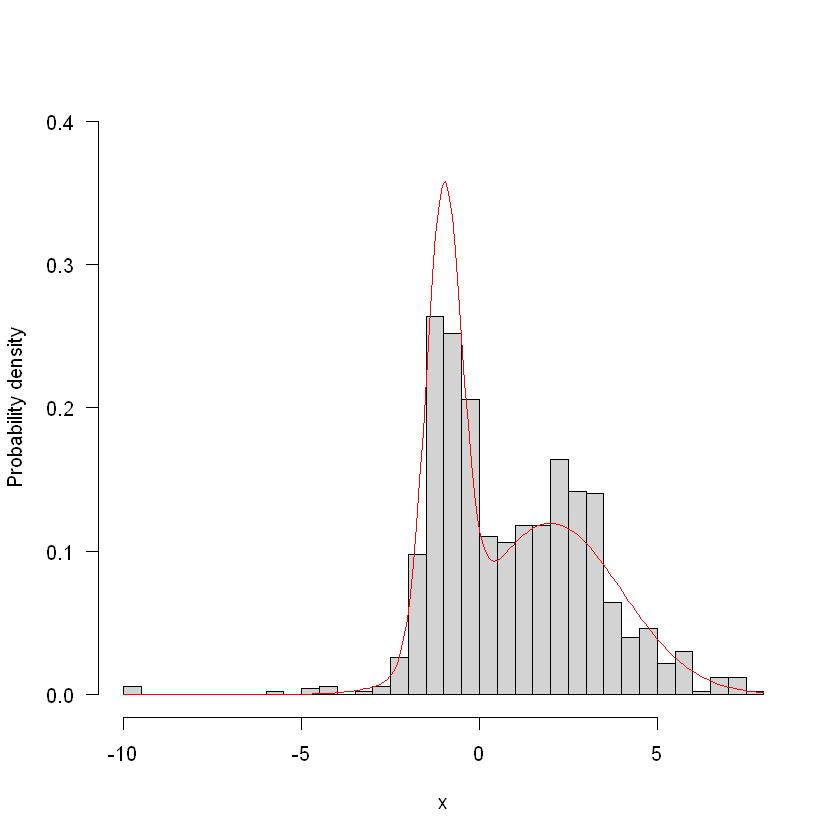

In [56]:
hist(res, 50, freq=FALSE, main="", ylim=c(0, .4), las=1,
     xlab="x", ylab="Probability density")
# potrebbe anche nascere un problema di inferenza del numero di bins 
z <- integrate(f, -Inf, Inf)$value
# normalizzazione per la distribuzione di probabilità
curve(f(x) / z, add=TRUE, col="red", n=200)
# il parametro add serve per mostrare due grafici nello stesso plot

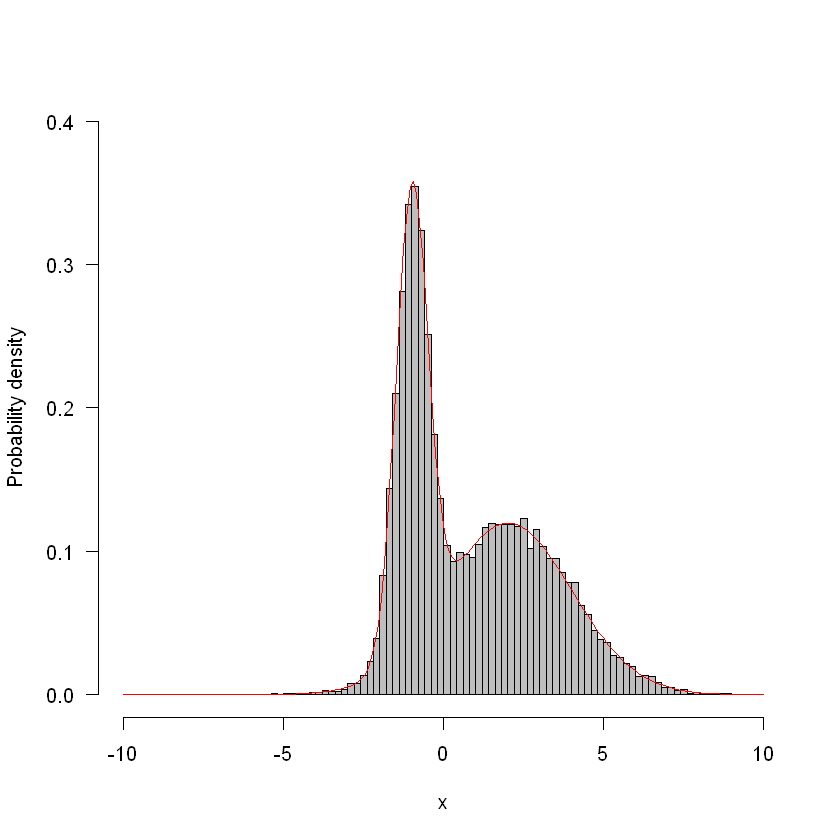

In [57]:
set.seed(1)
res.long <- run(-10, f, q, 50000)
hist(res.long, 100, freq=FALSE, main="", ylim=c(0, .4), las=1,
     xlab="x", ylab="Probability density", col="grey")
z <- integrate(f, -Inf, Inf)$value
curve(f(x) / z, add=TRUE, col="red", n=200)

#### Osservazioni 
Innanzitutto notiamo come al variare del numero di iterazioni la MCMC riesca a riempire correttamente il sample space della distribuzione di probabilità target ricostruendola fedelmente tramite un istogramma. Quest ultimo è ottenuto semplicemente sfruttando il tempo, ovvero il numero di volte, in cui un punto nella catena rimane in una particolare posizione. Al limite per il numero di iterazioni $N\to \infty$ si dimostra che l'algoritmo di Metropolis esplora tutte le regioni dello spazio dei parametri della distribuzione e la proposal distribution tende alla distribuzione target, ovvero MCMC converge ad un attrattore sdtabile che è effettivamente il target. 

Un altro parametro importante che influenza la velocità di convergenza dell'algoritmo è l'ampiezza del salto proposto dalla `proposal distribution`. Nell'esempio precedente infatti abbiamo estratto ciascun punto rispetto al quale ci saremmo mossi all'istante successivo da una distribuzione normale $\mathbf{N}(x,4)$ con valor medio $\mu=x$ centrato nel punto da cui viene proposto il salto e con deviazione standard $\sigma = 4$. Ciò significa che il 68% delle volte la gaussiana generava un proposal point entro un $\sigma$ dal punto nell'istante precedente dell'iterazione. Pertanto se lo spazio dei parametri fosse stato particolarmente ampio significa che l'algoritmo avrebbe impiegato sicuramente più tempo per convergere e cioè esplorare interamente il range(x).
Vediamo cosa succede cambiando proprio il parametro $\sigma$.

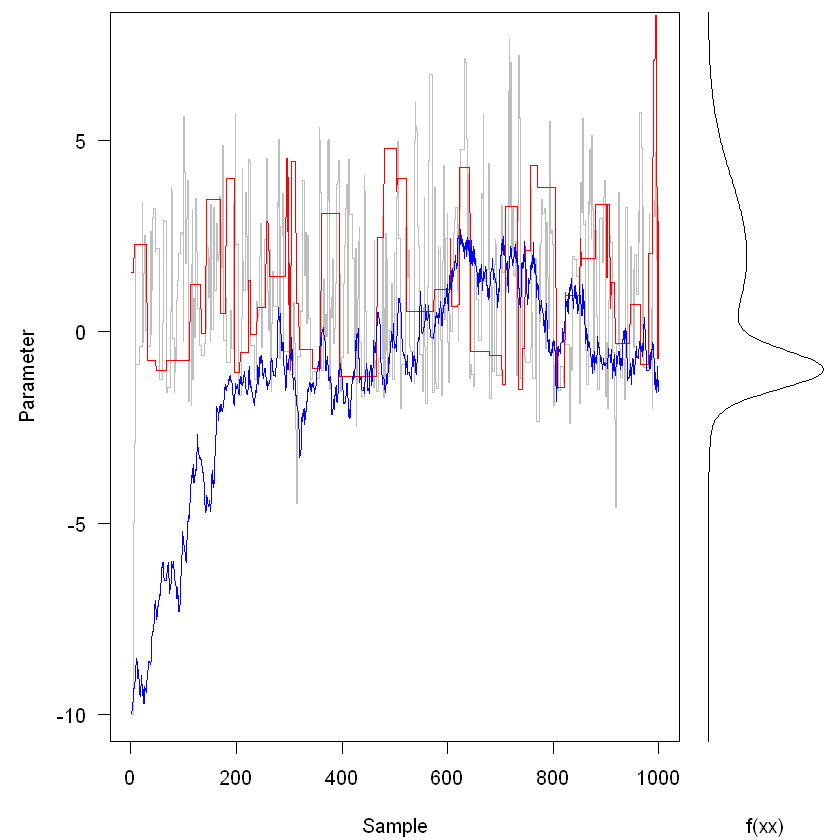

In [62]:
res.fast <- run(-10, f, function(x) rnorm(1, x,  33), 1000)
res.slow <- run(-10, f, function(x) rnorm(1, x,  .3), 1000)


layout(matrix(c(1, 2), 1, 2), widths=c(4, 1))
par(mar=c(4.1, .5, .5, .5), oma=c(0, 4.1, 0, 0))
plot(res, type="s", xpd=NA, ylab="Parameter", xlab="Sample", las=1,
     col="grey")
lines(res.fast, col="red")
lines(res.slow, col="blue")
plot(f(xx), xx, type="l", yaxs="i", axes=FALSE)

La traccia originale (linea grigia) varia abbastanza liberamente.

Al contrario, la traccia rossa (grande $\sigma$) suggerisce regioni terribili nello spazio delle probabilità e rifiuta la maggior parte delle proposte di "salto". Ciò significa che un punto tende a rimanere fermo per lungo tempo nello spazio dei parametri.

La traccia blu propone piccoli movimenti che tendono ad essere accettati, ma si muove seguendo un cammino casuale per la maggior parte della traiettoria. Occorrono centinaia di iterazioni per raggiungere anche il grosso della densità di probabilità.

È possibile vedere l'effetto di diversi $\sigma$ della `proposal distribution`  nell'autocorrelazione tra parametri successivi: questi grafici mostrano il decadimento del coefficiente di autocorrelazione tra step successivi, con le linee blu che indicano l'indipendenza statistica.

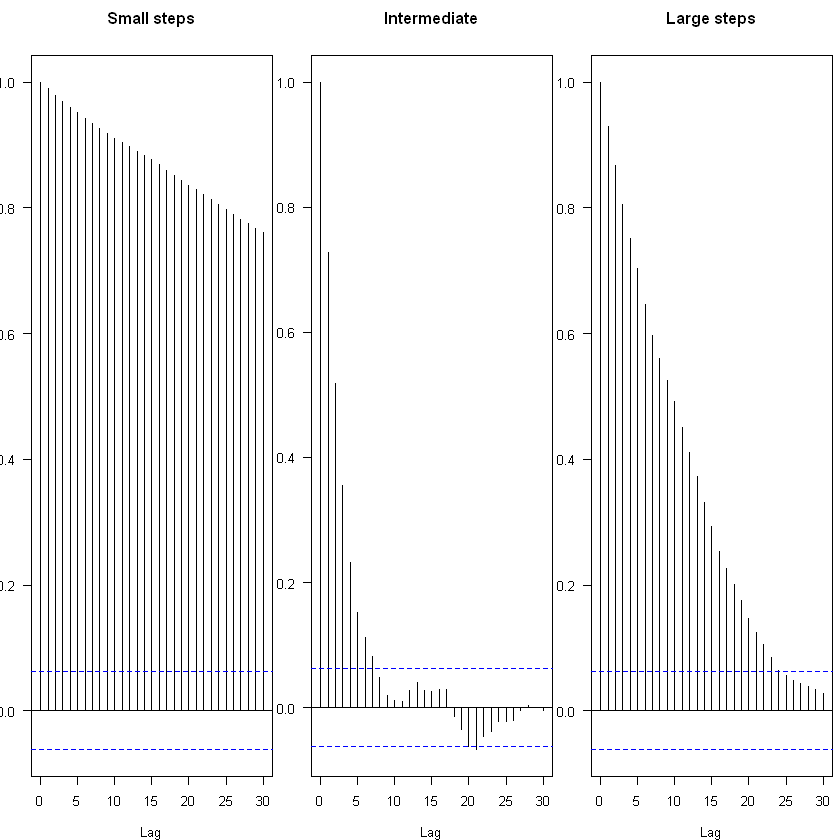

In [85]:
par(mfrow=c(1, 3), mar=c(4, 2, 3.5, .5))
# acf calcola e plotta l'autocorrelazione tra valori successivi rispetto al totale dei dati contenuti nel vettore
acf(res.slow, las=1, main="Small steps")
acf(res, las=1, main="Intermediate")
acf(res.fast, las=1, main="Large steps")

In [64]:
# queste funzioni appartengono alla libreria "conda"
effectiveSize(res)
effectiveSize(res.fast)
effectiveSize(res.slow)

var1 
157.5154

var1 
33.18961

var1 
5.377609

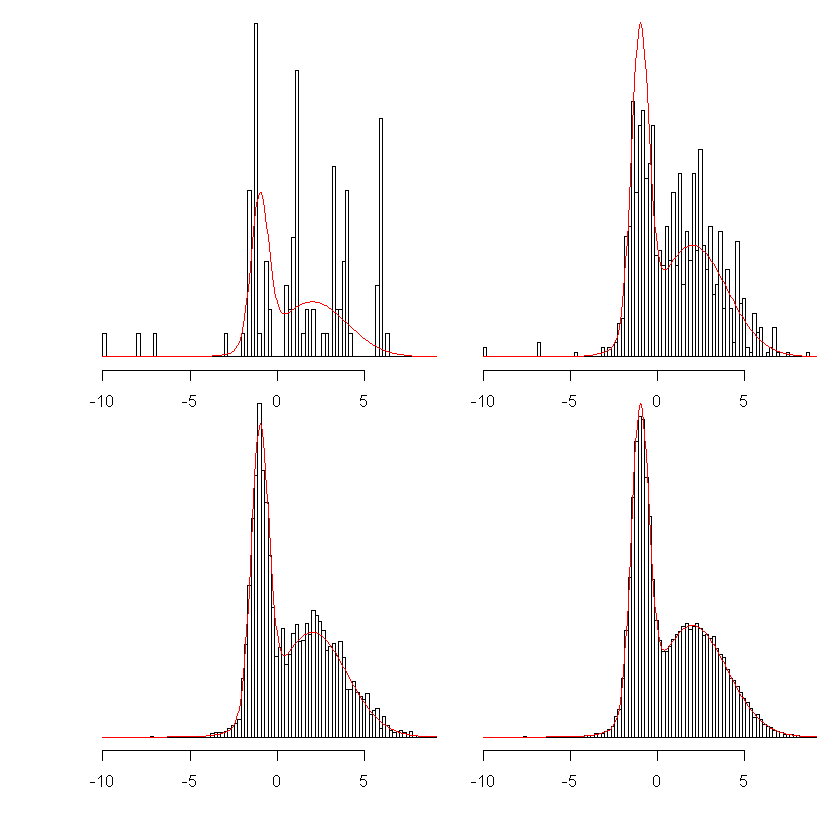

In [65]:
n <- 10^(2:5)
samples <- lapply(n, function(n) run(-10, f, q, n))
xlim <- range(sapply(samples, range))
# che è la stessa cosa di range(samples) 

br <- seq(xlim[1], xlim[2], length=100)

hh <- lapply(samples, function(x) hist(x, br, plot=FALSE))
ylim <- c(0, max(f(xx)))
# Showing 100, 1,000, 10,000 and 100,000 steps:

par(mfrow=c(2,2), mar=rep(.5, 4), oma=c(4, 4, 0, 0))
for (h in hh) {
    plot(h, main="", freq=FALSE, yaxt="n",
         ylim=range(h$density, ylim))
    curve(f(x), add=TRUE, col="red", n=300)
}

**MCMC in due dimensioni**

Essendo lo spazio dei parametri bidimensionale il vettore restituito come output dalla MCMC sarà una matrice $N$x$2$ nella quale le righe corrispondono al numero di iterazioni mentre le colonne ai punti assunti dopo ciascun salto in entrambe le direzioni.

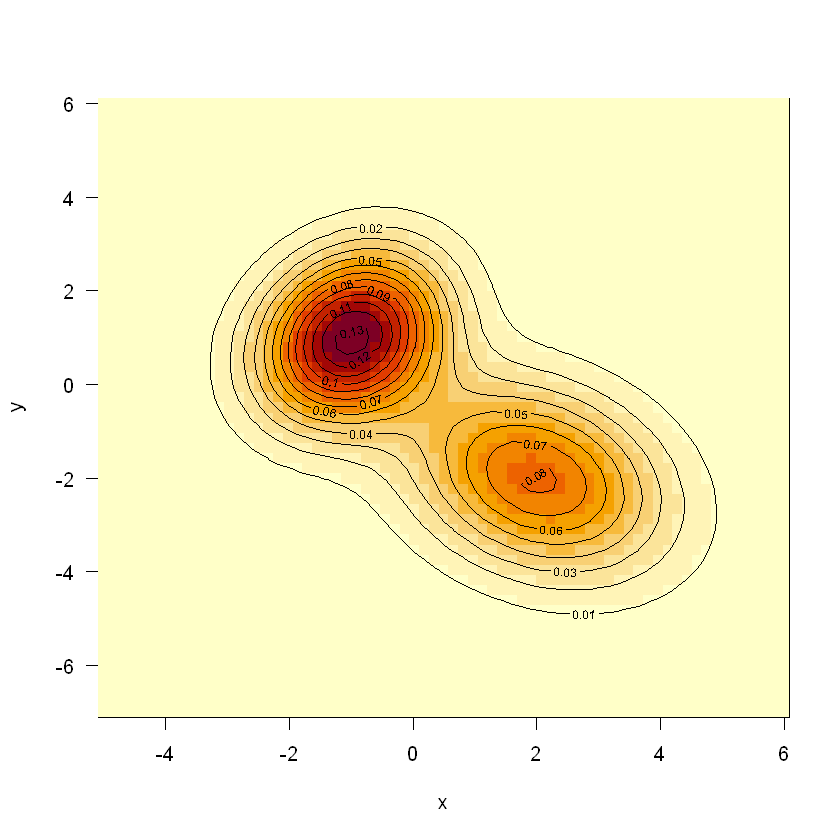

In [69]:
make.mvn <- function(mean, vcv) {
  logdet <- as.numeric(determinant(vcv, TRUE)$modulus)
  tmp <- length(mean) * log(2 * pi) + logdet
  vcv.i <- solve(vcv)

  function(x) {
    dx <- x - mean
    exp(-(tmp + rowSums((dx %*% vcv.i) * dx))/2)
  }
}

mu1 <- c(-1, 1)
mu2 <- c(2, -2)
vcv1 <- matrix(c(1, .25, .25, 1.5), 2, 2)
vcv2 <- matrix(c(2, -.5, -.5, 2), 2, 2)
f1 <- make.mvn(mu1, vcv1)
f2 <- make.mvn(mu2, vcv2)
f <- function(x)
    f1(x) + f2(x)

x <- seq(-5, 6, length=71)
y <- seq(-7, 6, length=61)
xy <- expand.grid(x=x, y=y)
z <- matrix(apply(as.matrix(xy), 1, f), length(x), length(y))

image(x, y, z, las=1)
contour(x, y, z, add=TRUE)


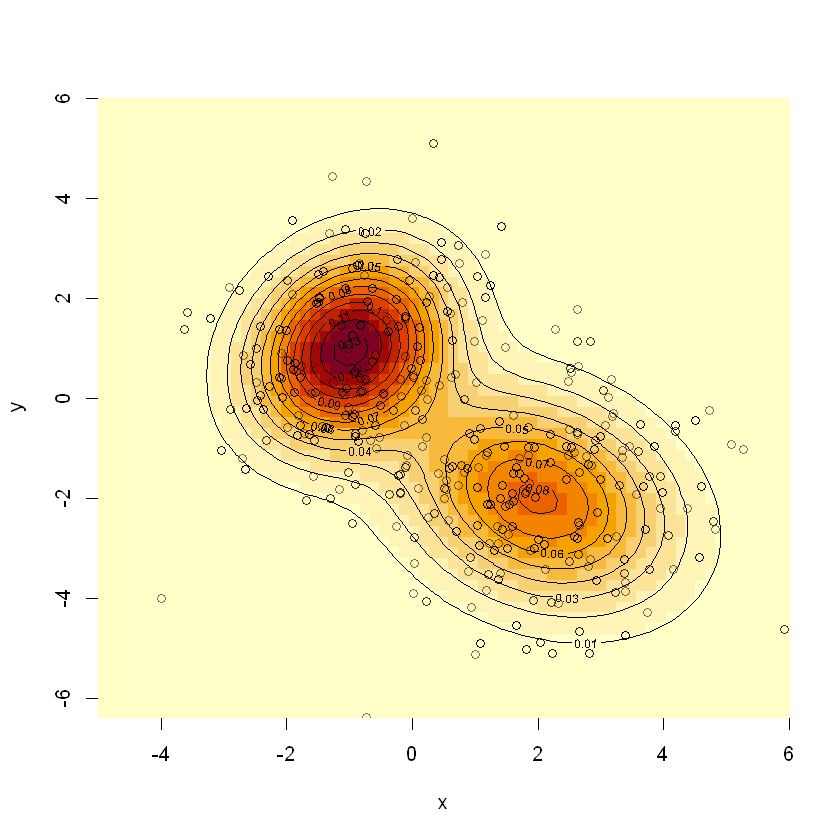

In [70]:
q <- function(x, d=8)
    x + runif(length(x), -d/2, d/2)

x0 <- c(-4, -4)
set.seed(1)
samples <- run(x0, f, q, 1000)

image(x, y, z, xlim=range(x, samples[,1]), ylim=range(x, samples[,2]))
contour(x, y, z, add=TRUE)
points(samples[,1], samples[,2], col="#00000088")

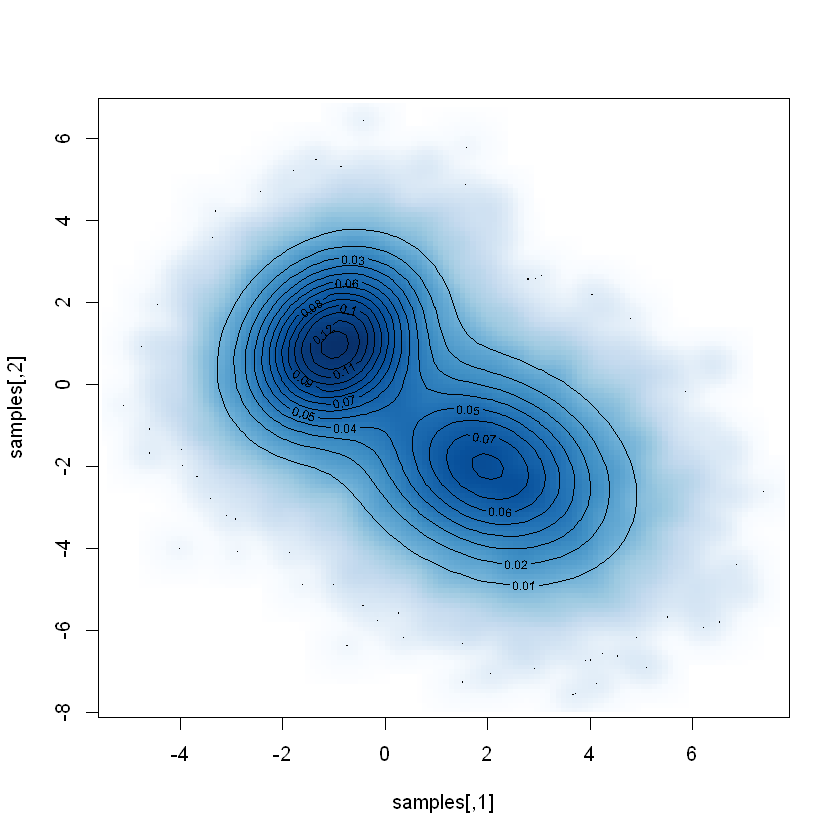

In [71]:
set.seed(1)
samples <- run(x0, f, q, 100000)


smoothScatter(samples, lwd=3)
contour(x, y, z, add=TRUE)

E' possibile, nota la distribuzione di probabilità joint dei due parametri tramite la MCMC, calcolare la probabilità marginale del parametro 1.
PERCHE ORA SPIEGO 

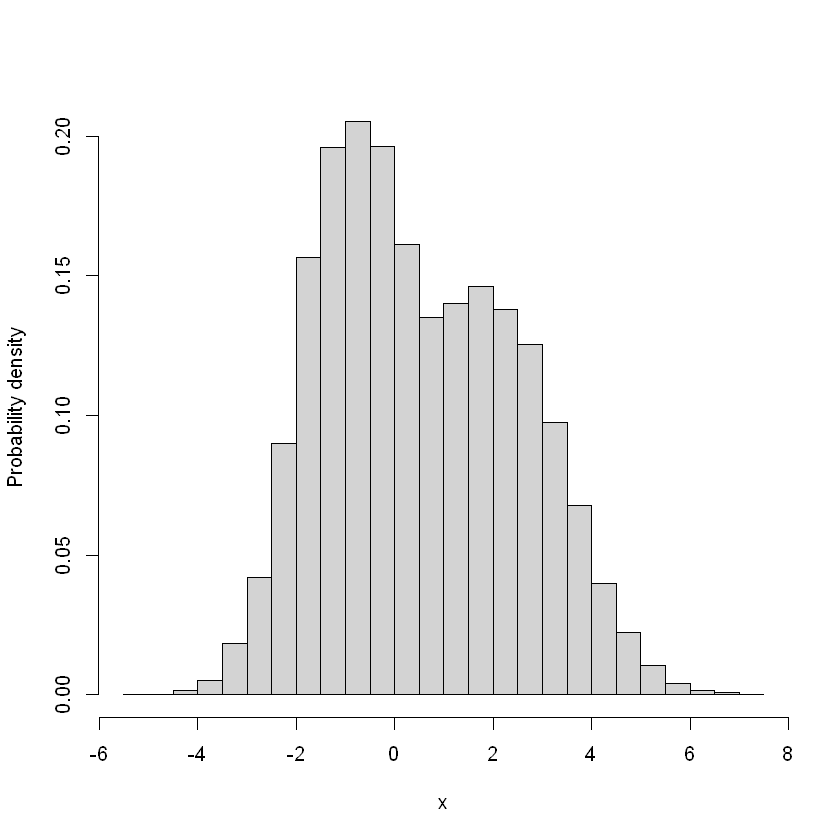

In [20]:
hist(samples[,1], freq=FALSE, main="", xlab="x",
     ylab="Probability density")

Che in teoria avremmo potuto ottenere integrando la multivariate gaussian sul secondo parametro.

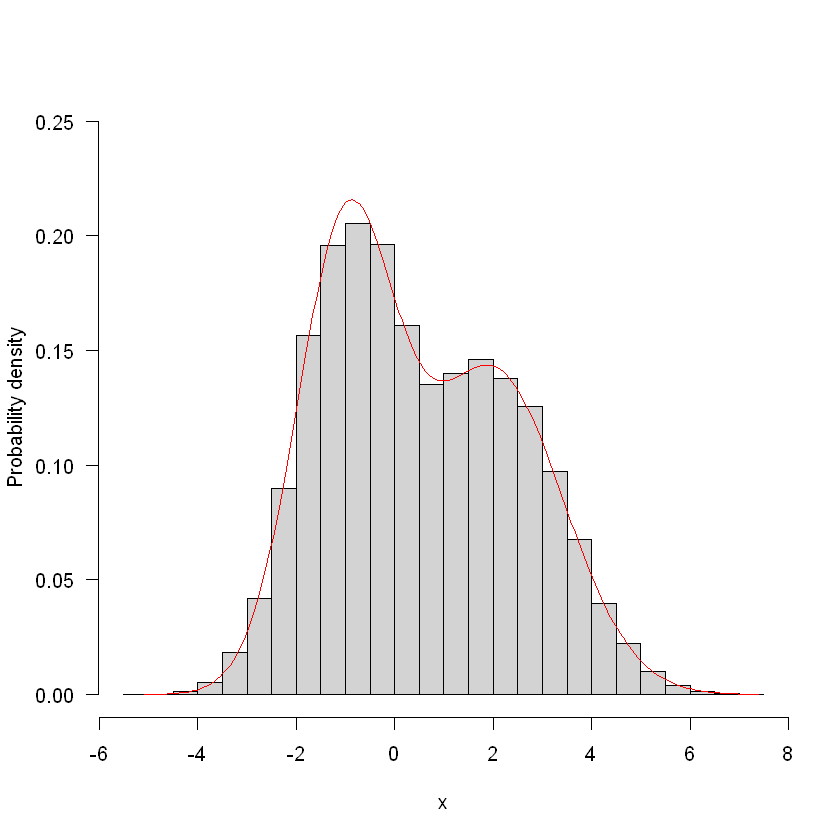

In [21]:
m <- function(x1) {
    g <- Vectorize(function(x2) f(c(x1, x2)))
    integrate(g, -Inf, Inf)$value
}

xx <- seq(min(samples[,1]), max(samples[,1]), length=201)
yy <- sapply(xx, m)
z <- integrate(splinefun(xx, yy), min(xx), max(xx))$value

hist(samples[,1], freq=FALSE, main="", las=1, xlab="x", 
     ylab="Probability density", ylim=c(0, 0.25))
lines(xx, yy/z, col="red")